<a href="https://colab.research.google.com/github/tmsandford/M33_Matching/blob/main/Auto_CMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%capture
!pip install --upgrade pip
!pip install vaex
!pip install -Iv ipython==7.0.0
!pip install astroquery
!sudo pip install numpy --upgrade --ignore-installed

#Restart runtime!

In [1]:
import sys
from astroquery.irsa import Irsa
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, fixed
import vaex


In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
datadir = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [3]:
def f_to_mag(flux):
    """Converts unWISE flux to Vega magnitude"""
    result = 22.5 - 2.5 * np.log10(flux)
    return result

In [34]:
def cmds(ra_min, ra_max, dec_min, dec_max, n=600):
   
    """unWISE sources scatter plot"""
    Irsa.ROW_LIMIT = 100000
    data_table = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=ra_min,dec=dec_min,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=ra_max,dec=dec_min,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=ra_max,dec=dec_max,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=ra_min,dec=dec_max,unit=(u.deg,u.deg),frame='icrs')])
    
    data_table['W1'] = f_to_mag(data_table['flux_1'])
    data_table['W2'] = f_to_mag(data_table['flux_2'])
    data_table['W2 - W1'] = data_table['W2'] - data_table['W1']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2);
    fig.set_figheight(25)
    fig.set_figwidth(25)
    
    ax1.set_xlabel('W2 - W1', fontsize=20)
    ax1.set_ylabel('W2', fontsize=20)
    ax1.scatter(data_table['W2 - W1'],data_table['W2'], s=10,c='black')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_title('unWISE', size=20)
    
    """HST sources 2d histograms"""  
    ds = vaex.open(datadir+'M33_full_matched.hdf5')
    ds.select((ds.RA > ra_min) & (ds.RA < ra_max) & (ds.DEC > dec_min) & (ds.DEC < dec_max),name='SUB')
    import img_scale
    
    ra,dec = ds.RA.evaluate(selection='SUB'),ds.DEC.evaluate(selection='SUB')
    ra_m33, dec_m33 = 23.462*u.deg, 30.66*u.deg
    aspect_ratio = (ra.max()-ra.min())*np.cos(np.pi/180.*dec_m33) / (dec.max()-dec.min())
    
    colormap = 'viridis'
    cmap = getattr(mpl.cm, colormap)
    cmap.set_under('w')

    ####F110W-F160W

    ds['F110W_F160W'] = ds.F110W_VEGA - ds.F160W_VEGA
    F110W_F160W,F160W = ds.F110W_F160W.evaluate(selection='SUB'),ds.F160W_VEGA.evaluate(selection='SUB')
    hall_1,h110_160,h160 = np.histogram2d(F110W_F160W,F160W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,6.5), (15, 34)],
                              density=False)

    hall_scaled1 = img_scale.log(hall_1,scale_min=1,scale_max=100);

    ax2.set_xlabel('F110W-F160W', fontsize=20);
    ax2.set_ylabel('F160W', fontsize=20);

    im2 = ax2.imshow(hall_scaled1.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h110_160[0],h110_160[-1],h160[0],h160[-1]],
               cmap=cmap,vmin=0.01,vmax=1);

    ax2.set_ylim(ax2.get_ylim()[::-1]);


    ###F814W-F110W

    ds['F814W_F110W'] = ds.F814W_VEGA - ds.F110W_VEGA
    F814W_F110W,F110W = ds.F814W_F110W.evaluate(selection='SUB'),ds.F110W_VEGA.evaluate(selection='SUB')
    hall_2,h814_110,h110 = np.histogram2d(F814W_F110W,F110W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,6.5), (15, 34)],
                              density=False)

    hall_scaled2 = img_scale.log(hall_2,scale_min=1,scale_max=100);

    ax3.set_xlabel('F814W-F110W', fontsize=20);
    ax3.set_ylabel('F110W', fontsize=20);

    im3 = ax3.imshow(hall_scaled2.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h814_110[0],h814_110[-1],h110[0],h110[-1]],
               cmap=cmap,vmin=0.01,vmax=1);

    ax3.set_ylim(ax3.get_ylim()[::-1]);

    ###F475W-F814W

    ds['F475W_F814W'] = ds.F475W_VEGA - ds.F814W_VEGA
    F475W_F814W,F814W = ds.F475W_F814W.evaluate(selection='SUB'),ds.F814W_VEGA.evaluate(selection='SUB')
    hall_3,h475_814,h814 = np.histogram2d(F475W_F814W,F814W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,6.5), (15, 34)],
                              density=False);

    hall_scaled3 = img_scale.log(hall_3,scale_min=1,scale_max=100);

    ax4.set_xlabel('F475W-F814W', fontsize=20);
    ax4.set_ylabel('F814W', fontsize=20);

    im4 = ax4.imshow(hall_scaled3.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h475_814[0],h475_814[-1],h814[0],h814[-1]],
               cmap=cmap,vmin=0.01,vmax=1);

    ax4.set_ylim(ax4.get_ylim()[::-1]);








img_scale : log
img_scale : log
img_scale : log


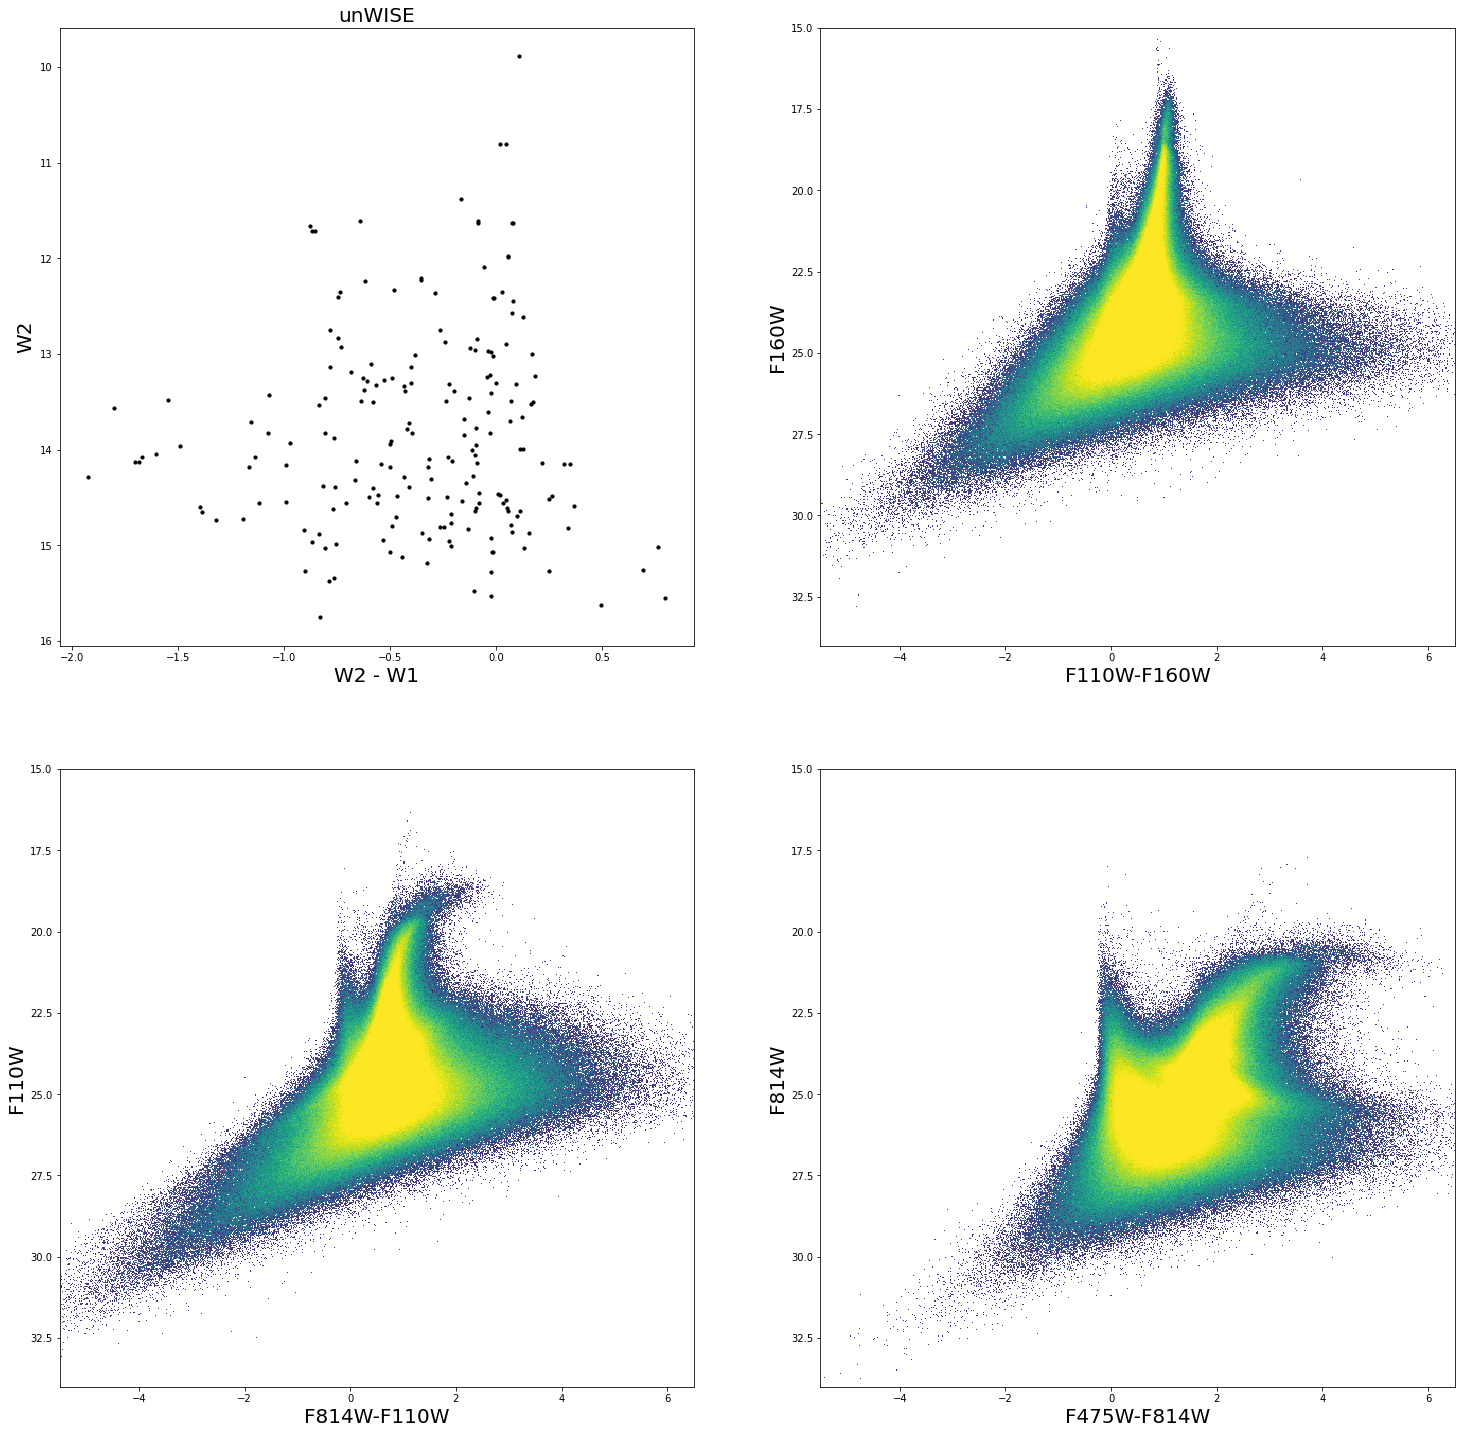

In [33]:
cmds(23.4, 23.5, 30.6, 30.7, 600)